# Deep learning with Keras II
https://www.pyimagesearch.com/2018/09/10/keras-tutorial-how-to-get-started-with-keras-deep-learning-and-python/

In [16]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.models import Sequential, load_model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os

## Settings

In [2]:
dataset = "animals"  # Path to input dataset of images

## Initialization

In [3]:
data = []
labels = []

# Grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images(dataset)))
random.seed(42)
random.shuffle(imagePaths)

# Loop over the input images
for imagePath in imagePaths:
    # Load the image, resize it to 64x64 pixels (the required input spatial dimensions
    # of SmallVGGNet), and store the image in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (64, 64))
    data.append(image)

    # Extract the class label from the image path and update the labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)
    
# Scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

## Partition the data
Partition the data into training and testing splits using 75% of the data for training and the remaining 25% for testing

In [4]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

Convert the labels from integers to vectors (for 2-class, binary classification you should use Keras' to_categorical function instead as the scikit-learn's LabelBinarizer will not return a vector)

In [5]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

## Define the architecture

In [6]:
class SmallVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # Initialize the model along with the input shape to be "channels last"
        # and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        
        # If we are using "channels first", update the input shape and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
            
        # CONV => RELU => POOL layer set
        model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # (CONV => RELU) * 2 => POOL layer set
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # (CONV => RELU) * 3 => POOL layer set
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # First (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # Softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        # Return the constructed network architecture
        return model

In [7]:
# Construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range=0.1,
                         shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")

# Initialize our VGG-like Convolutional Neural Network
model = SmallVGGNet.build(width=64, height=64, depth=3, classes=len(lb.classes_))

In [8]:
# Initialize our initial learning rate, # of epochs to train for and batch size
INIT_LR = 0.01
EPOCHS = 75
BS = 32

# Initialize the model and optimizer (you'll want to use binary_crossentropy for 2-class classification)
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

## Train the network

In [9]:
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS), validation_data=(testX, testY),
                        steps_per_epoch=len(trainX) // BS, epochs=EPOCHS)

Epoch 1/75
70/70 [==============================] - 18s 261ms/step - loss: 1.4208 - accuracy: 0.5104 - val_loss: 1.7010 - val_accuracy: 0.3147
Epoch 2/75
70/70 [==============================] - 18s 262ms/step - loss: 1.0521 - accuracy: 0.5798 - val_loss: 2.1645 - val_accuracy: 0.3147
Epoch 3/75
70/70 [==============================] - 18s 261ms/step - loss: 0.9558 - accuracy: 0.5839 - val_loss: 2.1904 - val_accuracy: 0.3147
Epoch 4/75
70/70 [==============================] - 18s 255ms/step - loss: 0.8605 - accuracy: 0.6060 - val_loss: 1.6061 - val_accuracy: 0.3200
Epoch 5/75
70/70 [==============================] - 18s 256ms/step - loss: 0.7737 - accuracy: 0.6312 - val_loss: 1.4733 - val_accuracy: 0.4013
Epoch 6/75
70/70 [==============================] - 18s 251ms/step - loss: 0.7513 - accuracy: 0.6407 - val_loss: 1.2958 - val_accuracy: 0.4640
Epoch 7/75
70/70 [==============================] - 17s 247ms/step - loss: 0.7379 - accuracy: 0.6483 - val_loss: 0.8181 - val_accuracy: 0.6320

Epoch 58/75
70/70 [==============================] - 18s 262ms/step - loss: 0.4678 - accuracy: 0.7831 - val_loss: 0.5842 - val_accuracy: 0.7573
Epoch 59/75
70/70 [==============================] - 18s 258ms/step - loss: 0.4532 - accuracy: 0.7899 - val_loss: 0.6604 - val_accuracy: 0.7360
Epoch 60/75
70/70 [==============================] - 19s 267ms/step - loss: 0.4574 - accuracy: 0.7940 - val_loss: 0.5623 - val_accuracy: 0.7587
Epoch 61/75
70/70 [==============================] - 18s 261ms/step - loss: 0.4545 - accuracy: 0.7928 - val_loss: 0.6200 - val_accuracy: 0.7160
Epoch 62/75
70/70 [==============================] - 18s 261ms/step - loss: 0.4717 - accuracy: 0.7808 - val_loss: 0.5747 - val_accuracy: 0.7667
Epoch 63/75
70/70 [==============================] - 20s 279ms/step - loss: 0.4315 - accuracy: 0.8079 - val_loss: 0.5890 - val_accuracy: 0.7493
Epoch 64/75
70/70 [==============================] - 20s 289ms/step - loss: 0.4167 - accuracy: 0.8156 - val_loss: 0.6672 - val_accuracy:

## Evaluate the model

              precision    recall  f1-score   support

        cats       0.65      0.81      0.72       236
        dogs       0.71      0.53      0.60       236
       panda       0.90      0.91      0.90       278

    accuracy                           0.76       750
   macro avg       0.75      0.75      0.74       750
weighted avg       0.76      0.76      0.75       750



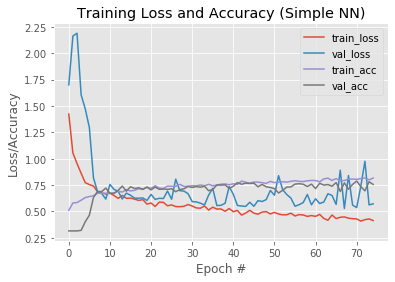

In [10]:
# Evaluate the network
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))

# Plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

## Save it to disk

In [14]:
model_path = "output/smallvggnet.model"
label_bin = "output/smallvggnet_lb.pickle"
model.save(model_path)
f = open(label_bin, "wb")
f.write(pickle.dumps(lb))
f.close()

## Make a prediction

In [21]:
image_path = "images/panda.jpg"

# Load the input image and resize it to the target spatial dimensions
image = cv2.imread(image_path)
output = image.copy()
image = cv2.resize(image, (64, 64))

# Scale the pixel values to [0, 1]
image = image.astype("float") / 255.0

image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

In [22]:
# Load the model and label binarizer
model = load_model(model_path)
lb = pickle.loads(open(label_bin, "rb").read())

# Make a prediction on the image
preds = model.predict(image)
print("Prediction:", preds)

# Find the class label index with the largest corresponding probability
i = preds.argmax(axis=1)[0]
label = lb.classes_[i]

Prediction: [[2.6821058e-07 4.2468705e-06 9.9999547e-01]]


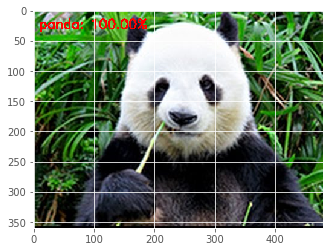

In [23]:
# Draw the class label + probability on the output image
text = "{}: {:.2f}%".format(label, preds[0][i] * 100)
cv2.putText(output, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

# Show the output image
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
plt.imshow(output)